In [4]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob

In [ ]:
# Constants
RTM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\RTM_images'
DTM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\DTM_images'
ATM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\ATM_images'

IMG_SIZE = (32, 32)
SEQ_LEN = 5

In [6]:
# === Utility ===
def load_img_uint8(path):
    img = load_img(path, color_mode='grayscale', target_size=IMG_SIZE)
    return img_to_array(img).astype(np.uint8)

# === Index Dataset ===
def index_sequences(rtm_path, dtm_path, atm_path, seq_len=5, exclude=None):
    train, test, gestures = [], [], set()
    exclude = set(exclude or [])
    for person in sorted(os.listdir(rtm_path)):
        if person in exclude:
            target = test
        else:
            target = train
        for session in os.listdir(os.path.join(rtm_path, person)):
            for gesture in os.listdir(os.path.join(rtm_path, person, session)):
                rtm_files = sorted(glob(os.path.join(rtm_path, person, session, gesture, '*.png')))
                dtm_files = sorted(glob(os.path.join(dtm_path, person, session, gesture, '*.png')))
                atm_files = sorted(glob(os.path.join(atm_path, person, session, gesture, '*.png')))
                n = min(len(rtm_files), len(dtm_files), len(atm_files))
                gestures.add(gesture)
                for i in range(n - seq_len + 1):
                    target.append({
                        'rtm': rtm_files[i:i+seq_len],
                        'dtm': dtm_files[i:i+seq_len],
                        'atm': atm_files[i:i+seq_len],
                        'label': gesture
                    })
    label_map = {g: i for i, g in enumerate(sorted(gestures))}
    train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)
    return train_data, val_data, test, label_map

# === Data Generator ===
class SingleInputSequence(Sequence):
    def __init__(self, samples, label_map, batch_size=64, seq_len=5, shuffle_data=False):
        self.samples = samples
        self.label_map = label_map
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.shuffle_data = shuffle_data
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle_data:
            self.samples = shuffle(self.samples)

    def __getitem__(self, idx):
        batch = self.samples[idx * self.batch_size: (idx + 1) * self.batch_size]
        X, y = [], []
        for sample in batch:
            rtm = [load_img_uint8(p) for p in sample['rtm']]
            dtm = [load_img_uint8(p) for p in sample['dtm']]
            atm = [load_img_uint8(p) for p in sample['atm']]
            sequence = np.concatenate(rtm + dtm + atm, axis=0)  # shape: (15*32, 32, 1)
            X.append(sequence)
            y.append(self.label_map[sample['label']])
        X = np.array(X).astype(np.float32) / 255.0  # shape: (B, 480, 32, 1)
        return X, np.array(y)

In [7]:
excluded = {f'p0_{i}' for i in range(15, 21)}  # Exclude p0_15 to p0_20
train_samples, val_samples, test_samples, label_map = index_sequences(
    RTM_PATH, DTM_PATH, ATM_PATH, seq_len=SEQ_LEN, exclude=excluded
)

# Instantiate generators
train_gen = SingleInputSequence(train_samples, label_map, batch_size=128, shuffle_data=True)
val_gen = SingleInputSequence(val_samples, label_map, batch_size=128, shuffle_data=False)

# Teacher

In [8]:
def build_multi_cnn_lstm_teacher(input_shape=(480, 32, 1), seq_len=5, img_size=(32, 32, 1), num_classes=13):
    inputs = tf.keras.Input(shape=input_shape, name="input")

    # === Split input into sequences ===
    # Total = 15 slices: 5 rtm, 5 dtm, 5 atm → each (32, 32, 1)
    def slice_and_reshape(start_idx):
        def fn(x):
            x = x[:, start_idx*32:(start_idx+seq_len)*32, :, :]  # Slice rows
            return tf.reshape(x, (-1, seq_len, 32, 32, 1))       # Reshape to (B, 5, 32, 32, 1)
        return layers.Lambda(fn)

    rtm_seq = slice_and_reshape(0)(inputs)   # Rows 0-160
    dtm_seq = slice_and_reshape(5)(inputs)   # Rows 160-320
    atm_seq = slice_and_reshape(10)(inputs)  # Rows 320-480

    # === CNN encoder ===
    def build_single_cnn():
        input_layer = tf.keras.Input(shape=img_size)
        x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(input_layer)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Flatten()(x)
        x = layers.Dense(128, activation='relu')(x)
        return models.Model(inputs=input_layer, outputs=x)

    cnn_encoder = build_single_cnn()

    # Apply TimeDistributed CNN on each branch
    rtm_encoded = layers.TimeDistributed(cnn_encoder)(rtm_seq)
    dtm_encoded = layers.TimeDistributed(cnn_encoder)(dtm_seq)
    atm_encoded = layers.TimeDistributed(cnn_encoder)(atm_seq)

    # Concatenate sequences → shape: (batch, time, features * 3)
    merged = layers.Concatenate(axis=-1)([rtm_encoded, dtm_encoded, atm_encoded])

    # Temporal modeling
    x = layers.LSTM(128, return_sequences=False)(merged)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=output)


# Student

In [16]:
def build_stm32_deployable_model(input_shape=(480, 32, 1), num_classes=13):
    inputs = tf.keras.Input(shape=input_shape, name="input")

    # === 1. Split Input ===
    rtm = layers.Cropping2D(((0, 320), (0, 0)))(inputs)     # 0:160
    dtm = layers.Cropping2D(((160, 160), (0, 0)))(inputs)   # 160:320
    atm = layers.Cropping2D(((320, 0), (0, 0)))(inputs)     # 320:480

    def cnn_branch():
        inp = tf.keras.Input(shape=(160, 32, 1))
        x = layers.Conv2D(16, 3, activation='relu', padding='same')(inp)
        x = layers.DepthwiseConv2D(3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D(2)(x)  # 80x16x16

        x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D(2)(x)  # 40x8x32

        x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
        x = layers.GlobalAveragePooling2D()(x)  # -> (64,)
        return tf.keras.Model(inp, x)

    branch = cnn_branch()

    feat_rtm = branch(rtm)
    feat_dtm = branch(dtm)
    feat_atm = branch(atm)

    # === 2. Temporal Fusion (simulated LSTM) ===
    x = layers.Concatenate()( [feat_rtm, feat_dtm, feat_atm] )  # (192,)
    x = layers.Reshape((3, 64))(x)  # (3, 64)

    x = layers.Conv1D(64, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)  # instead of GlobalAvgPool1D

    # === 3. MLP Head ===
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

In [ ]:
teacher = build_multi_cnn_lstm_teacher()

In [11]:
# Train the teacher first
teacher.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
teacher.fit(train_gen, validation_data=val_gen, epochs=40)


Epoch 1/40


51/51 [==============================] - 31s 570ms/step - loss: 1.4993 - accuracy: 0.4948 - val_loss: 0.9232 - val_accuracy: 0.6734
Epoch 2/40
51/51 [==============================] - 27s 533ms/step - loss: 0.7784 - accuracy: 0.7191 - val_loss: 0.7159 - val_accuracy: 0.7566
Epoch 3/40
51/51 [==============================] - 27s 536ms/step - loss: 0.5537 - accuracy: 0.8001 - val_loss: 0.5147 - val_accuracy: 0.8244
Epoch 4/40
51/51 [==============================] - 27s 532ms/step - loss: 0.4306 - accuracy: 0.8451 - val_loss: 0.4100 - val_accuracy: 0.8521
Epoch 5/40
51/51 [==============================] - 27s 538ms/step - loss: 0.3277 - accuracy: 0.8847 - val_loss: 0.3588 - val_accuracy: 0.8749
Epoch 6/40
51/51 [==============================] - 27s 535ms/step - loss: 0.2742 - accuracy: 0.8995 - val_loss: 0.3100 - val_accuracy: 0.8916
Epoch 7/40
51/51 [==============================] - 28s 541ms/step - loss: 0.2066 - accuracy: 0.9294 - val_loss: 0.2560 - val_accuracy: 0.9

In [12]:
teacher.save('teacher_model_cnn_lstm.h5')

c:\Users\ioana\anaconda3\envs\tiny_radar\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Student Training

In [15]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from matplotlib import pyplot as plt


Epoch 1/55


Train Acc: 0.1724 | Val Acc: 0.2865


Saved best student model to Models/saved_student_checkpoints\best_student_epoch01_acc0.2865.h5

Epoch 2/55


Train Acc: 0.3749 | Val Acc: 0.4079


Saved best student model to Models/saved_student_checkpoints\best_student_epoch02_acc0.4079.h5

Epoch 3/55


Train Acc: 0.4232 | Val Acc: 0.4202


Saved best student model to Models/saved_student_checkpoints\best_student_epoch03_acc0.4202.h5

Epoch 4/55


Train Acc: 0.4357 | Val Acc: 0.4295


Saved best student model to Models/saved_student_checkpoints\best_student_epoch04_acc0.4295.h5

Epoch 5/55


Train Acc: 0.4486 | Val Acc: 0.4424


Saved best student model to Models/saved_student_checkpoints\best_student_epoch05_acc0.4424.h5

Epoch 6/55


Train Acc: 0.4591 | Val Acc: 0.4461


Saved best student model to Models/saved_student_checkpoints\best_student_epoch06_acc0.4461.h5

Epoch 7/55


Train Acc: 0.4850 | Val Acc: 0.5003


Saved best student model to Models/saved_student_checkpoints\best_student_epoch07_acc0.5003.h5

Epoch 8/55


Train Acc: 0.5175 | Val Acc: 0.5059


Saved best student model to Models/saved_student_checkpoints\best_student_epoch08_acc0.5059.h5

Epoch 9/55


Train Acc: 0.5384 | Val Acc: 0.5151


Saved best student model to Models/saved_student_checkpoints\best_student_epoch09_acc0.5151.h5

Epoch 10/55


Train Acc: 0.5643 | Val Acc: 0.5453


Saved best student model to Models/saved_student_checkpoints\best_student_epoch10_acc0.5453.h5

Epoch 11/55


Train Acc: 0.5927 | Val Acc: 0.5570


Saved best student model to Models/saved_student_checkpoints\best_student_epoch11_acc0.5570.h5

Epoch 12/55


Train Acc: 0.6124 | Val Acc: 0.5909


Saved best student model to Models/saved_student_checkpoints\best_student_epoch12_acc0.5909.h5

Epoch 13/55


Train Acc: 0.6314 | Val Acc: 0.6094


Saved best student model to Models/saved_student_checkpoints\best_student_epoch13_acc0.6094.h5

Epoch 14/55


Train Acc: 0.6508 | Val Acc: 0.6297


Saved best student model to Models/saved_student_checkpoints\best_student_epoch14_acc0.6297.h5

Epoch 15/55


Train Acc: 0.6622 | Val Acc: 0.6463


Saved best student model to Models/saved_student_checkpoints\best_student_epoch15_acc0.6463.h5

Epoch 16/55


Train Acc: 0.6802 | Val Acc: 0.6624


Saved best student model to Models/saved_student_checkpoints\best_student_epoch16_acc0.6624.h5

Epoch 17/55


Train Acc: 0.6858 | Val Acc: 0.6673


Saved best student model to Models/saved_student_checkpoints\best_student_epoch17_acc0.6673.h5

Epoch 18/55


Train Acc: 0.6932 | Val Acc: 0.6728


Saved best student model to Models/saved_student_checkpoints\best_student_epoch18_acc0.6728.h5

Epoch 19/55


Train Acc: 0.6990 | Val Acc: 0.6839


Saved best student model to Models/saved_student_checkpoints\best_student_epoch19_acc0.6839.h5

Epoch 20/55


Train Acc: 0.7041 | Val Acc: 0.6962


Saved best student model to Models/saved_student_checkpoints\best_student_epoch20_acc0.6962.h5

Epoch 21/55


Train Acc: 0.7120 | Val Acc: 0.6999


Saved best student model to Models/saved_student_checkpoints\best_student_epoch21_acc0.6999.h5

Epoch 22/55


Train Acc: 0.7189 | Val Acc: 0.7098


Saved best student model to Models/saved_student_checkpoints\best_student_epoch22_acc0.7098.h5

Epoch 23/55


Train Acc: 0.7243 | Val Acc: 0.7116


Saved best student model to Models/saved_student_checkpoints\best_student_epoch23_acc0.7116.h5

Epoch 24/55


Train Acc: 0.7291 | Val Acc: 0.7178


Saved best student model to Models/saved_student_checkpoints\best_student_epoch24_acc0.7178.h5

Epoch 25/55


Train Acc: 0.7359 | Val Acc: 0.7258


Saved best student model to Models/saved_student_checkpoints\best_student_epoch25_acc0.7258.h5

Epoch 26/55


Train Acc: 0.7422 | Val Acc: 0.7289


Saved best student model to Models/saved_student_checkpoints\best_student_epoch26_acc0.7289.h5

Epoch 27/55


Train Acc: 0.7423 | Val Acc: 0.7332


Saved best student model to Models/saved_student_checkpoints\best_student_epoch27_acc0.7332.h5

Epoch 28/55


Train Acc: 0.7468 | Val Acc: 0.7406


Saved best student model to Models/saved_student_checkpoints\best_student_epoch28_acc0.7406.h5

Epoch 29/55


Train Acc: 0.7510 | Val Acc: 0.7511


Saved best student model to Models/saved_student_checkpoints\best_student_epoch29_acc0.7511.h5

Epoch 30/55


Train Acc: 0.7584 | Val Acc: 0.7591


Saved best student model to Models/saved_student_checkpoints\best_student_epoch30_acc0.7591.h5

Epoch 31/55


Train Acc: 0.7622 | Val Acc: 0.7616


Saved best student model to Models/saved_student_checkpoints\best_student_epoch31_acc0.7616.h5

Epoch 32/55


Train Acc: 0.7654 | Val Acc: 0.7677


Saved best student model to Models/saved_student_checkpoints\best_student_epoch32_acc0.7677.h5

Epoch 33/55


Train Acc: 0.7718 | Val Acc: 0.7696


Saved best student model to Models/saved_student_checkpoints\best_student_epoch33_acc0.7696.h5

Epoch 34/55


Train Acc: 0.7753 | Val Acc: 0.7683

Epoch 35/55


Train Acc: 0.7784 | Val Acc: 0.7708


Saved best student model to Models/saved_student_checkpoints\best_student_epoch35_acc0.7708.h5

Epoch 36/55


Train Acc: 0.7812 | Val Acc: 0.7702

Epoch 37/55


Train Acc: 0.7804 | Val Acc: 0.7726


Saved best student model to Models/saved_student_checkpoints\best_student_epoch37_acc0.7726.h5

Epoch 38/55


Train Acc: 0.7815 | Val Acc: 0.7776


Saved best student model to Models/saved_student_checkpoints\best_student_epoch38_acc0.7776.h5

Epoch 39/55


Train Acc: 0.7824 | Val Acc: 0.7825


Saved best student model to Models/saved_student_checkpoints\best_student_epoch39_acc0.7825.h5

Epoch 40/55


Train Acc: 0.7870 | Val Acc: 0.7794

Epoch 41/55


Train Acc: 0.7953 | Val Acc: 0.7831


Saved best student model to Models/saved_student_checkpoints\best_student_epoch41_acc0.7831.h5

Epoch 42/55


Train Acc: 0.7969 | Val Acc: 0.7813

Epoch 43/55


Train Acc: 0.8007 | Val Acc: 0.7893


Saved best student model to Models/saved_student_checkpoints\best_student_epoch43_acc0.7893.h5

Epoch 44/55


Train Acc: 0.8052 | Val Acc: 0.7967


Saved best student model to Models/saved_student_checkpoints\best_student_epoch44_acc0.7967.h5

Epoch 45/55


Train Acc: 0.8069 | Val Acc: 0.7998


Saved best student model to Models/saved_student_checkpoints\best_student_epoch45_acc0.7998.h5

Epoch 46/55


Train Acc: 0.8088 | Val Acc: 0.7967

Epoch 47/55


Train Acc: 0.8138 | Val Acc: 0.7998

Epoch 48/55


Train Acc: 0.8178 | Val Acc: 0.8004


Saved best student model to Models/saved_student_checkpoints\best_student_epoch48_acc0.8004.h5

Epoch 49/55


Train Acc: 0.8200 | Val Acc: 0.8028


Saved best student model to Models/saved_student_checkpoints\best_student_epoch49_acc0.8028.h5

Epoch 50/55


Train Acc: 0.8237 | Val Acc: 0.8078


Saved best student model to Models/saved_student_checkpoints\best_student_epoch50_acc0.8078.h5

Epoch 51/55


Train Acc: 0.8220 | Val Acc: 0.8102


Saved best student model to Models/saved_student_checkpoints\best_student_epoch51_acc0.8102.h5

Epoch 52/55


Train Acc: 0.8269 | Val Acc: 0.8115


Saved best student model to Models/saved_student_checkpoints\best_student_epoch52_acc0.8115.h5

Epoch 53/55


Train Acc: 0.8263 | Val Acc: 0.8102

Epoch 54/55


Train Acc: 0.8291 | Val Acc: 0.8108

Epoch 55/55


Train Acc: 0.8309 | Val Acc: 0.8115


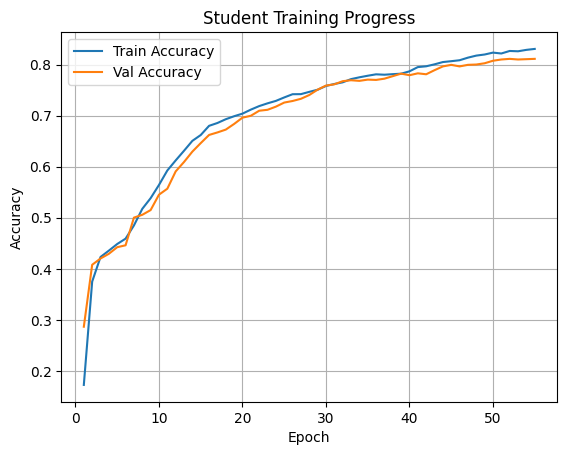

In [18]:
EPOCHS_PHASE1 = 15
EPOCHS_PHASE2 = 40
TOTAL_EPOCHS = EPOCHS_PHASE1 + EPOCHS_PHASE2
TEMPERATURE = 5.0
ALPHA = 0.5  # Weight for distillation loss
CHECKPOINT_DIR = "Models/saved_student_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# === One-hot loss and metrics ===
loss_ce = CategoricalCrossentropy()
train_acc_metric = CategoricalAccuracy()
val_acc_metric = CategoricalAccuracy()

# === Prepare teacher and student ===
student = build_stm32_deployable_model(input_shape=(480, 32, 1), num_classes=13)
teacher = tf.keras.models.load_model("teacher_model_cnn_lstm.h5")
teacher.trainable = False  # Freeze teacher

# === Optimizer ===
optimizer = tf.keras.optimizers.Adam()

# === Metric tracking ===
train_accs, val_accs = [], []
best_val_acc = 0.0

# === Utility: one-hot encode labels ===
def one_hot(y, num_classes):
    return tf.one_hot(y, depth=num_classes)

# === Distillation Loss Function ===
def distillation_loss(y_true, y_pred_student, y_pred_teacher, temperature=1.0, alpha=0.5):
    y_true_onehot = one_hot(tf.cast(y_true, tf.int32), y_pred_student.shape[-1])
    ce_loss = loss_ce(y_true_onehot, y_pred_student)

    # Soft targets
    y_teacher_soft = tf.nn.softmax(y_pred_teacher / temperature)
    y_student_soft = tf.nn.log_softmax(y_pred_student / temperature)
    kl_loss = tf.reduce_mean(tf.reduce_sum(y_teacher_soft * (tf.math.log(y_teacher_soft + 1e-8) - y_student_soft), axis=1))
    kl_loss *= temperature ** 2

    return alpha * ce_loss + (1 - alpha) * kl_loss

# === Training Loop ===
from tqdm import tqdm 

for epoch in range(1, TOTAL_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{TOTAL_EPOCHS}")
    train_acc_metric.reset_states()

    # === Train ===
    train_bar = tqdm(train_gen, desc=f"Training Epoch {epoch}", leave=False)
    for X_batch, y_batch in train_bar:
        with tf.GradientTape() as tape:
            y_logits_student = student(X_batch, training=True)
            if epoch <= EPOCHS_PHASE1:
                y_loss = loss_ce(one_hot(y_batch, 13), y_logits_student)
            else:
                y_logits_teacher = teacher(X_batch, training=False)
                y_loss = distillation_loss(y_batch, y_logits_student, y_logits_teacher,
                                           temperature=TEMPERATURE, alpha=ALPHA)

        grads = tape.gradient(y_loss, student.trainable_variables)
        optimizer.apply_gradients(zip(grads, student.trainable_variables))
        train_acc_metric.update_state(one_hot(y_batch, 13), y_logits_student)
        train_bar.set_postfix(loss=float(y_loss), acc=float(train_acc_metric.result()))

    train_acc = train_acc_metric.result().numpy()
    train_accs.append(train_acc)

    # === Validate ===
    val_acc_metric.reset_states()
    val_bar = tqdm(val_gen, desc=f"Validating Epoch {epoch}", leave=False)
    for X_batch, y_batch in val_bar:
        val_logits = student(X_batch, training=False)
        val_acc_metric.update_state(one_hot(y_batch, 13), val_logits)
        val_bar.set_postfix(acc=float(val_acc_metric.result()))

    val_acc = val_acc_metric.result().numpy()
    val_accs.append(val_acc)

    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # === Save if best ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model_path = os.path.join(CHECKPOINT_DIR, f"best_student_epoch{epoch:02d}_acc{val_acc:.4f}.h5")
        student.save(model_path)
        print(f"Saved best student model to {model_path}")

# === Plot Accuracies ===
plt.plot(range(1, TOTAL_EPOCHS + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, TOTAL_EPOCHS + 1), val_accs, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Student Training Progress")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
student.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 480, 32, 1)]         0         []                            
                                                                                                  
 cropping2d_6 (Cropping2D)   (None, 160, 32, 1)           0         ['input[0][0]']               
                                                                                                  
 cropping2d_7 (Cropping2D)   (None, 160, 32, 1)           0         ['input[0][0]']               
                                                                                                  
 cropping2d_8 (Cropping2D)   (None, 160, 32, 1)           0         ['input[0][0]']               
                                                                                            

In [21]:
student.save('deployable_3CNN_Distilation.h5')

c:\Users\ioana\anaconda3\envs\tiny_radar\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 10ms/step


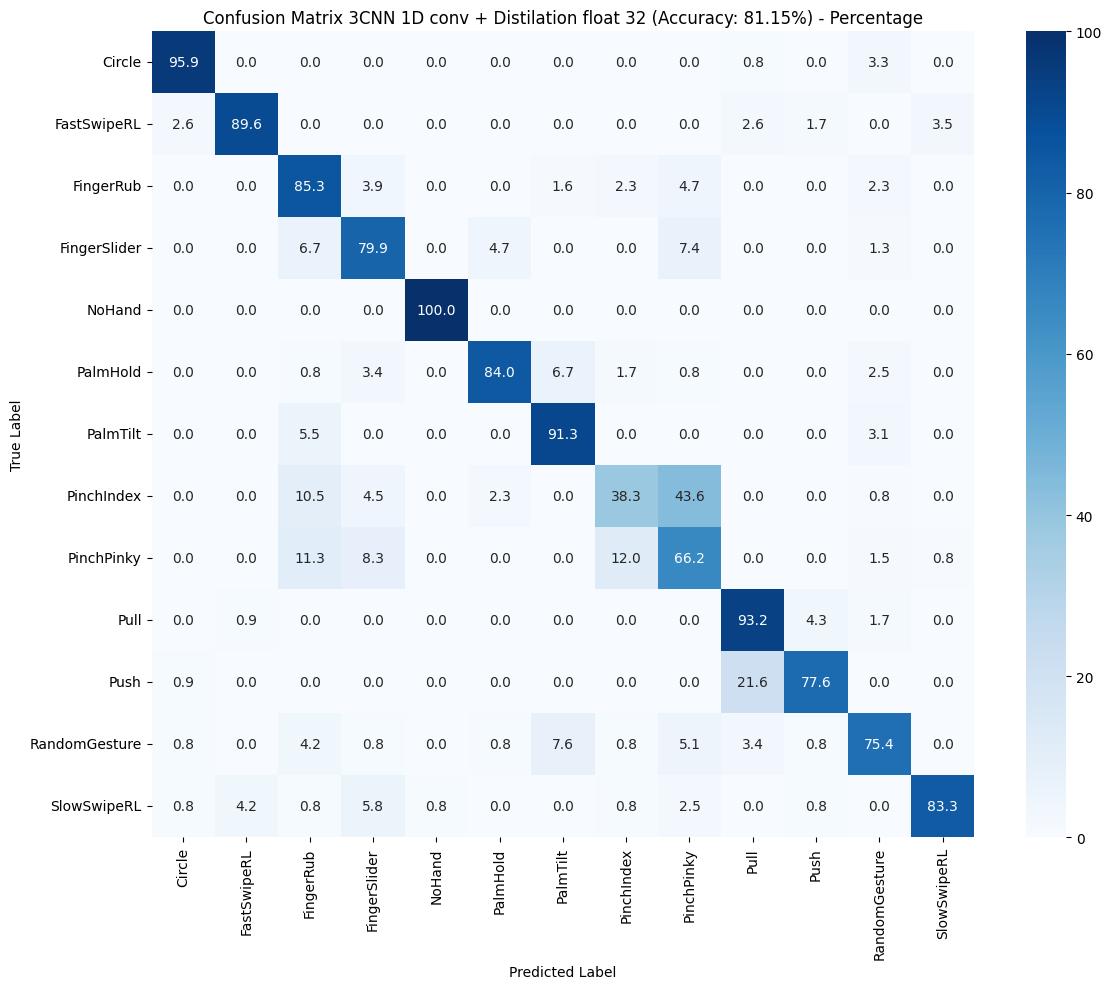

               precision    recall  f1-score   support

       Circle      0.952     0.959     0.955       123
  FastSwipeRL      0.945     0.896     0.920       115
    FingerRub      0.675     0.853     0.753       129
 FingerSlider      0.778     0.799     0.788       149
       NoHand      0.992     1.000     0.996       124
     PalmHold      0.901     0.840     0.870       119
     PalmTilt      0.859     0.913     0.885       127
   PinchIndex      0.689     0.383     0.493       133
   PinchPinky      0.509     0.662     0.575       133
         Pull      0.768     0.932     0.842       117
         Push      0.909     0.776     0.837       116
RandomGesture      0.809     0.754     0.781       118
  SlowSwipeRL      0.952     0.833     0.889       120

     accuracy                          0.811      1623
    macro avg      0.826     0.815     0.814      1623
 weighted avg      0.821     0.811     0.809      1623



In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

exclude_labels = {}
label_to_idx = {label: idx for label, idx in label_map.items() if label not in exclude_labels}
idx_to_label = {v: k for k, v in label_to_idx.items()}

# Inverse mapping for lookup
valid_indices = set(label_to_idx.values())

y_true, y_pred = [], []
for X, y in val_gen:
    preds = student.predict(X)
    for true_label, pred_logits in zip(y, preds):
        if int(true_label) in valid_indices:
            y_true.append(int(true_label))
            y_pred.append(np.argmax(pred_logits))

# Reindex labels to remove gaps caused by excluded labels
original_to_new_idx = {old: new for new, old in enumerate(sorted(valid_indices))}
new_class_names = [idx_to_label[i] for i in sorted(valid_indices)]

# Remap y_true and y_pred
y_true_mapped = [original_to_new_idx[y] for y in y_true]
y_pred_mapped = [original_to_new_idx[y] for y in y_pred]

# Metrics
cm = confusion_matrix(y_true_mapped, y_pred_mapped)
acc = accuracy_score(y_true_mapped, y_pred_mapped)
report = classification_report(y_true_mapped, y_pred_mapped, target_names=new_class_names, digits=3)

# Normalize the confusion matrix row-wise to get percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=new_class_names, yticklabels=new_class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix 3CNN 1D conv + Distilation float 32 (Accuracy: {acc:.2%}) - Percentage")
plt.tight_layout()
plt.show()

# Print classification report
print(report)

# Converting to TFLite

In [ ]:
# Reload it to ensure clean state
# model = tf.keras.models.load_model("deployable_3CNN_Distilation.h5")
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.evaluate(val_gen)

13/13 [==============================] - 7s 438ms/step - loss: 0.5506 - accuracy: 0.7831


[0.5506397485733032, 0.7831177115440369]

In [25]:
# === Wrap with fixed batch size ===
fixed_input = tf.keras.Input(batch_input_shape=(1, 480, 32, 1), name="input")
fixed_output = student(fixed_input)
wrapped_model = tf.keras.Model(inputs=fixed_input, outputs=fixed_output)

# === Save as TFLite ===
converter = tf.lite.TFLiteConverter.from_keras_model(wrapped_model)
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

tflite_model = converter.convert()
with open("deployable_3CNN_Distilation_float32.tflite", "wb") as f:
    f.write(tflite_model)

print(" Model wrapped and saved with fixed batch size: (1, 480, 32, 1)")

INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmpdjd4f52j\assets


INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmpdjd4f52j\assets


 Model wrapped and saved with fixed batch size: (1, 480, 32, 1)


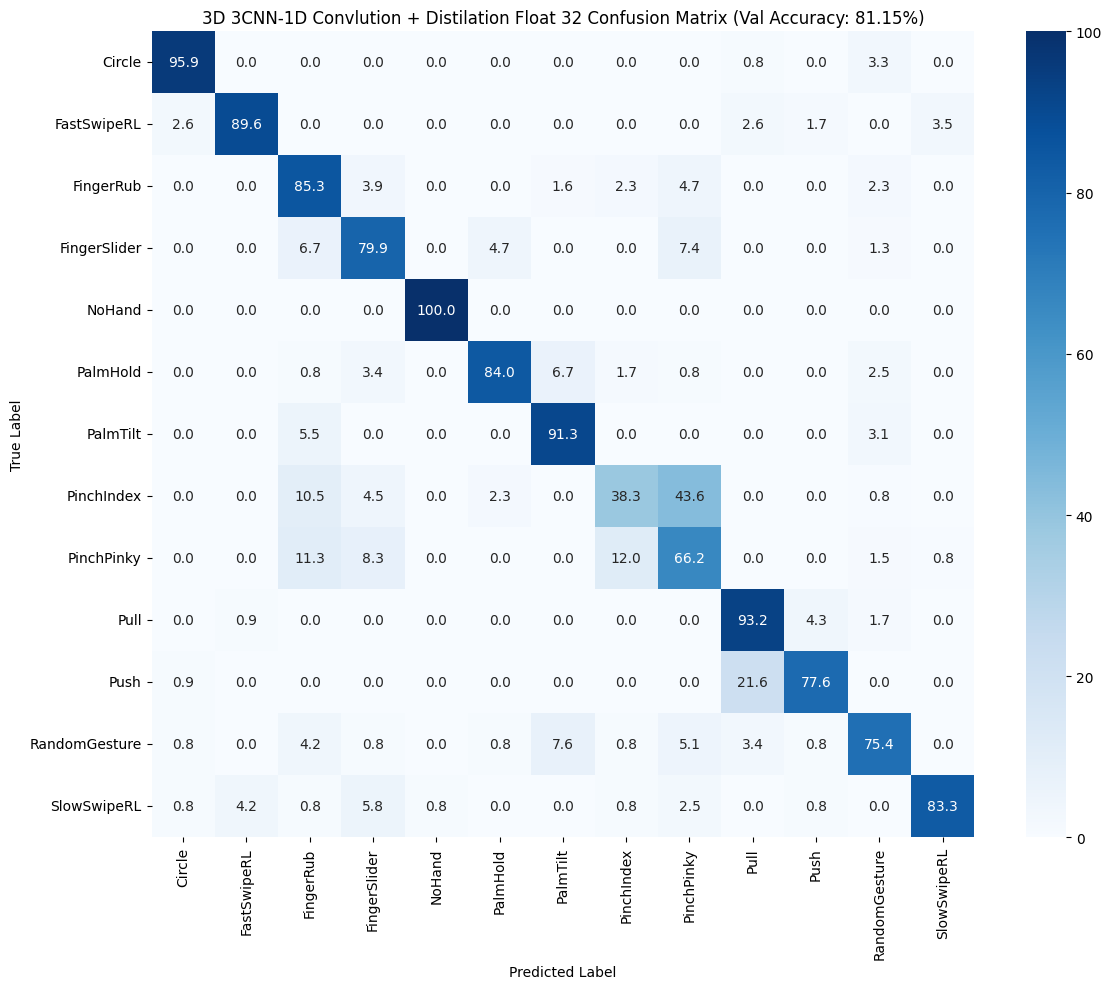

Classification Report:
                precision    recall  f1-score   support

       Circle      0.952     0.959     0.955       123
  FastSwipeRL      0.945     0.896     0.920       115
    FingerRub      0.675     0.853     0.753       129
 FingerSlider      0.778     0.799     0.788       149
       NoHand      0.992     1.000     0.996       124
     PalmHold      0.901     0.840     0.870       119
     PalmTilt      0.859     0.913     0.885       127
   PinchIndex      0.689     0.383     0.493       133
   PinchPinky      0.509     0.662     0.575       133
         Pull      0.768     0.932     0.842       117
         Push      0.909     0.776     0.837       116
RandomGesture      0.809     0.754     0.781       118
  SlowSwipeRL      0.952     0.833     0.889       120

     accuracy                          0.811      1623
    macro avg      0.826     0.815     0.814      1623
 weighted avg      0.821     0.811     0.809      1623



In [27]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="deployable_3CNN_Distilation_float32.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to predict using TFLite
def predict_tflite_sequence(sequence):
    # Ensure float32 and normalized
    sequence = sequence.astype(np.float32)
    # Add batch dimension
    input_tensor = np.expand_dims(sequence, axis=0)  
    # Set tensor and invoke
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    # Extract prediction
    output = interpreter.get_tensor(output_details[0]['index'])
    return np.argmax(output, axis=1)[0]

# Evaluate on val set
y_true, y_pred = [], []
for X, y in val_gen:
    for i in range(len(X)):
        pred = predict_tflite_sequence(X[i])
        y_true.append(int(y[i]))
        y_pred.append(int(pred))

# Get full label list
idx_to_label = {v: k for k, v in label_map.items()}
class_names = [idx_to_label[i] for i in range(len(label_map))]

# Metrics
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, digits=3)

# Normalize CM to show percentages
cm_percent = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True) * 100

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"3D 3CNN-1D Convlution + Distilation Float 32 Confusion Matrix (Val Accuracy: {acc:.2%})")
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:\n", report)

# Quantizing to Int8

In [28]:
# === Fixed batch-size wrapper ===
fixed_input = tf.keras.Input(batch_input_shape=(1, 480, 32, 1), name="input")
fixed_output = student(fixed_input)
wrapped_model = tf.keras.Model(inputs=fixed_input, outputs=fixed_output)

# === Representative dataset: yield one sample with correct shape (1, 480, 32, 1) ===
def representative_dataset():
    for i in range(100):
        x, _ = train_gen[i]
        for sample in x:
            sample = sample.astype(np.float32)
            yield [np.expand_dims(sample, axis=0)]  # shape: (1, 480, 32, 1)

# === Convert model to full INT8 with fixed shape ===
converter = tf.lite.TFLiteConverter.from_keras_model(wrapped_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert and save
tflite_model = converter.convert()
with open("deployable_3CNN_Distilation_int8.tflite", "wb") as f:
    f.write(tflite_model)

print("Full INT8 TFLite model saved with fixed batch size: (1, 480, 32, 1)")

INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmpsavz69ah\assets


INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmpsavz69ah\assets
c:\Users\ioana\anaconda3\envs\tiny_radar\lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Full INT8 TFLite model saved with fixed batch size: (1, 480, 32, 1)


Testing

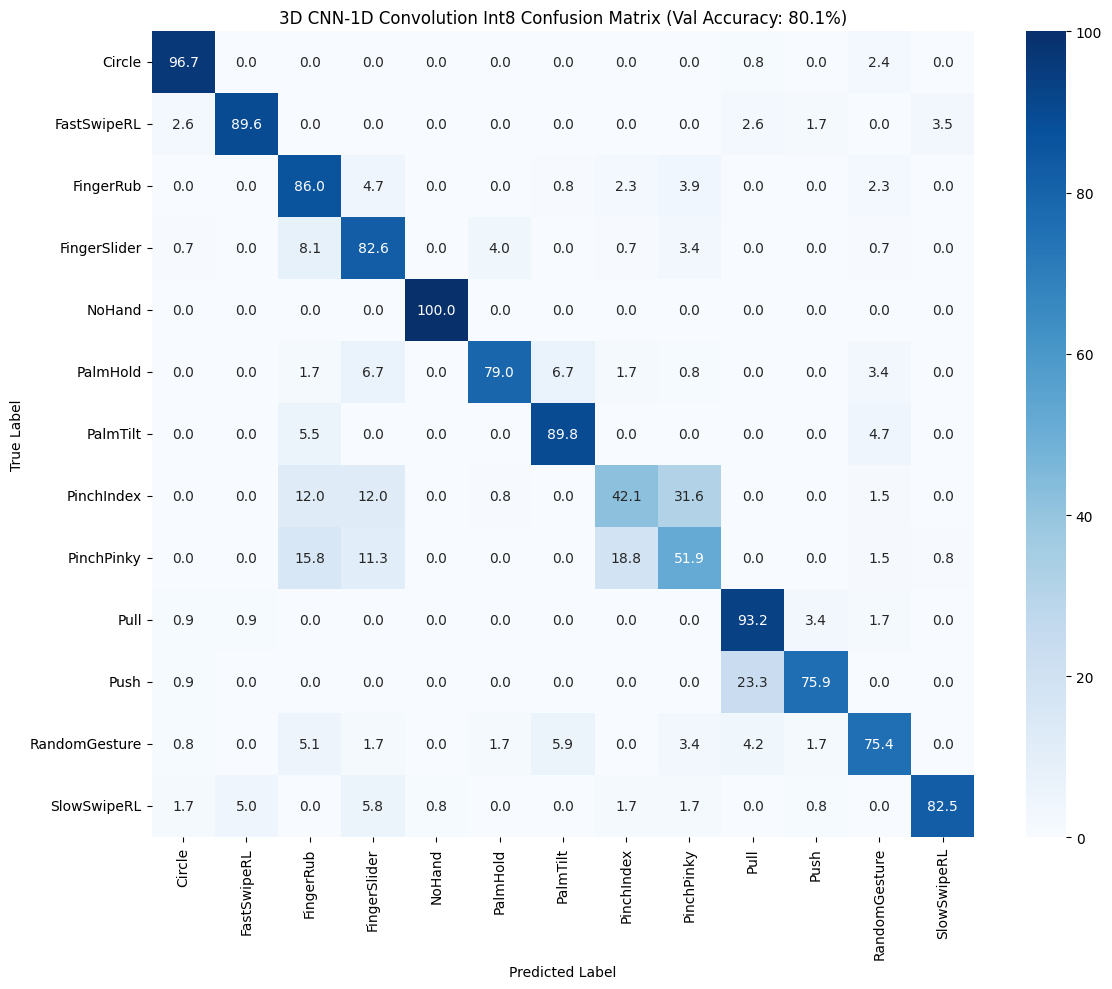

Classification Report:
                precision    recall  f1-score   support

       Circle      0.930     0.967     0.948       123
  FastSwipeRL      0.936     0.896     0.916       115
    FingerRub      0.634     0.860     0.730       129
 FingerSlider      0.695     0.826     0.755       149
       NoHand      0.992     1.000     0.996       124
     PalmHold      0.913     0.790     0.847       119
     PalmTilt      0.877     0.898     0.887       127
   PinchIndex      0.629     0.421     0.505       133
   PinchPinky      0.539     0.519     0.529       133
         Pull      0.752     0.932     0.832       117
         Push      0.907     0.759     0.826       116
RandomGesture      0.795     0.754     0.774       118
  SlowSwipeRL      0.952     0.825     0.884       120

     accuracy                          0.800      1623
    macro avg      0.812     0.804     0.802      1623
 weighted avg      0.805     0.800     0.797      1623



In [ ]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="deployable_3CNN_Distilation_int8.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to predict using TFLite
def predict_tflite_sequence(sequence):
    # Get scale and zero-point for quantization
    scale, zero_point = input_details[0]['quantization']

    # Normalize input (assuming it was float32 [0,1])
    sequence = sequence.astype(np.float32)

    # Quantize to int8
    sequence_q = (sequence / scale + zero_point).astype(np.int8)
    input_tensor = np.expand_dims(sequence_q, axis=0)  # Add batch dim

    # Set and run
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()

    # Dequantize output if needed
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return np.argmax(output_data, axis=1)[0]

# Evaluate on val set
y_true, y_pred = [], []
for X, y in val_gen:
    for i in range(len(X)):
        pred = predict_tflite_sequence(X[i])
        y_true.append(int(y[i]))
        y_pred.append(int(pred))

# Get full label list
idx_to_label = {v: k for k, v in label_map.items()}
class_names = [idx_to_label[i] for i in range(len(label_map))]

# Metrics
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, digits=3)

# Normalize CM to show percentages
cm_percent = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True) * 100

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"3D CNN-1D Convolution Int8 Confusion Matrix (Val Accuracy: {acc:.2%})")
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:\n", report)

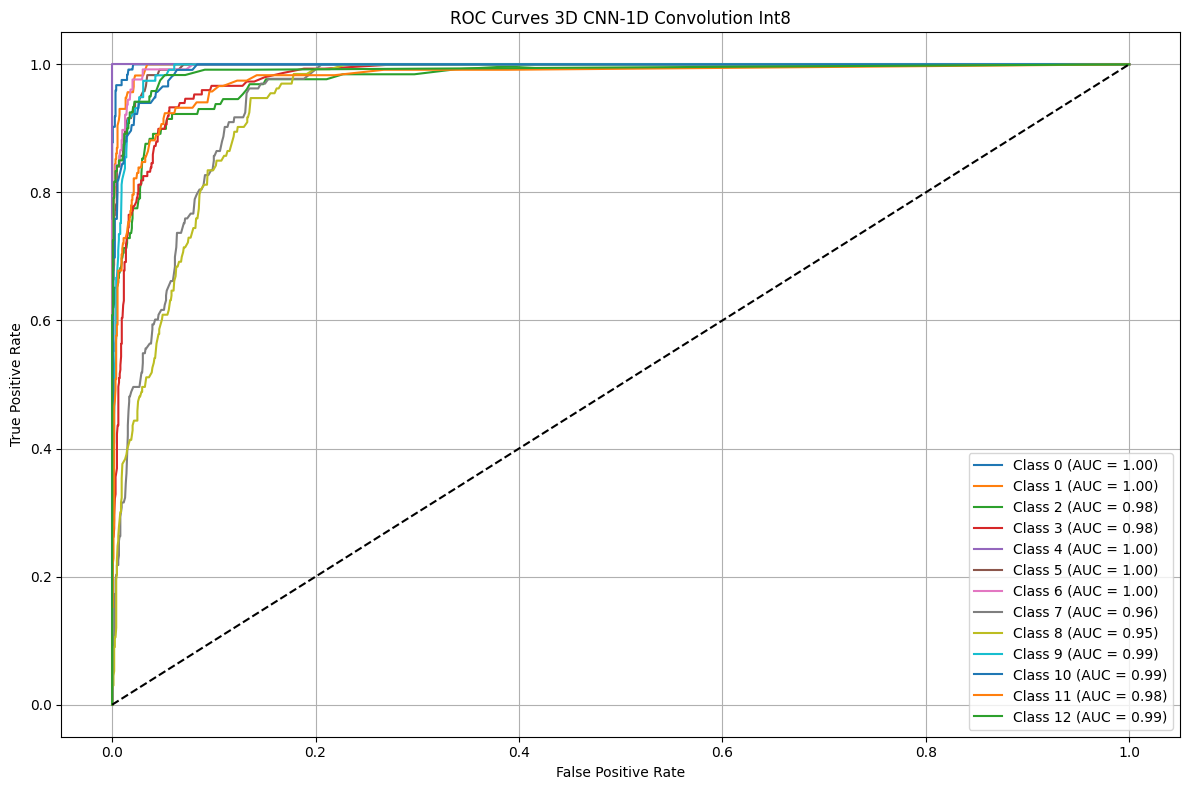

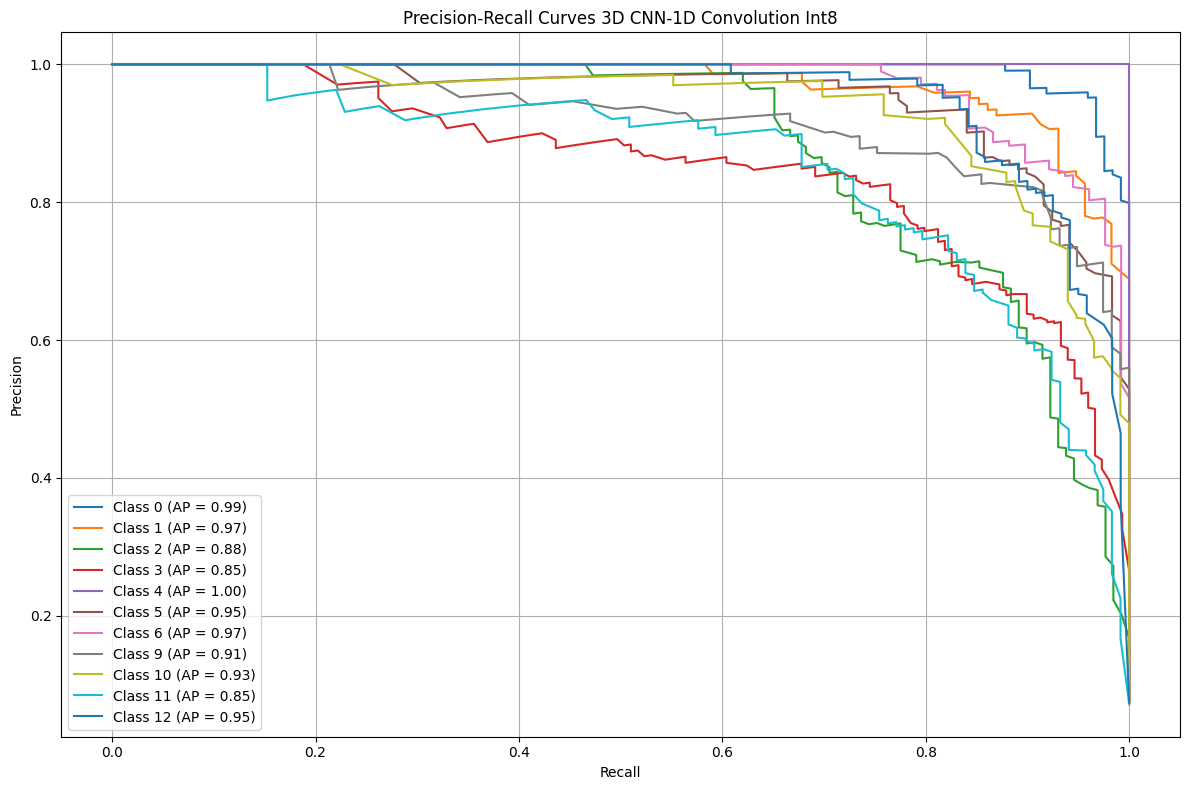

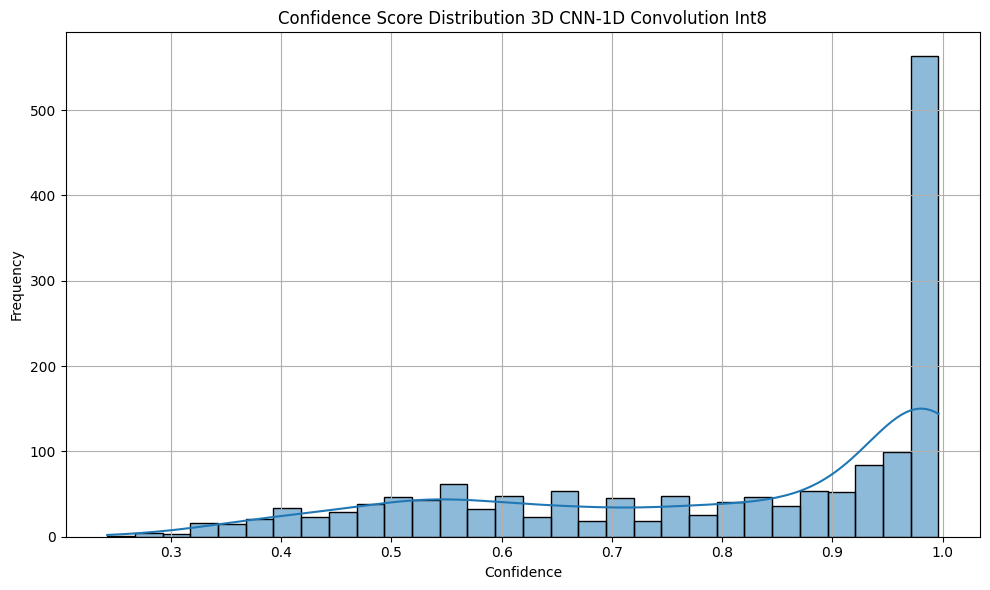

In [ ]:
# Load TFLite model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

interpreter = tf.lite.Interpreter(model_path=r"\Code\model_training_grayscale_images\deployable_3CNN_Distilation_int8.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_tflite_proba(sequence):
    # Quantization parameters for the input
    scale, zero_point = input_details[0]['quantization']
    
    # Quantize float32 input to int8
    input_tensor = (sequence / scale + zero_point).astype(np.int8)
    input_tensor = np.expand_dims(input_tensor, axis=0)  # Add batch dimension

    # Run inference
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()

    # Dequantize output (optional but useful for ROC/PR curves)
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]
    out_scale, out_zero_point = output_details[0]['quantization']
    output_dequant = (output_data.astype(np.float32) - out_zero_point) * out_scale

    return output_dequant

# Gather predictions and scores
y_true, y_scores = [], []
for X_batch, y_batch in val_gen:
    for i in range(len(X_batch)):
        y_true.append(int(y_batch[i]))
        y_scores.append(predict_tflite_proba(X_batch[i]))

y_true = np.array(y_true)
y_scores = np.array(y_scores)
y_pred = np.argmax(y_scores, axis=1)

# Convert labels to one-hot for metrics
n_classes = len(label_map)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# ROC Curve
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves 3D CNN-1D Convolution Int8")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_scores[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP = {avg_precision:.2f})")
plt.title("Precision-Recall Curves 3D CNN-1D Convolution Int8")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Confidence Score Distribution
conf_scores = np.max(y_scores, axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(conf_scores, bins=30, kde=True)
plt.title("Confidence Score Distribution 3D CNN-1D Convolution Int8")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.tight_layout()
plt.grid()
plt.show()

In [35]:
# int  8 model size
import os
model_size = os.path.getsize("deployable_3CNN_Distilation_int8.tflite") / (1024 )  # in KB
print(f"INT8 TFLite model size: {model_size:.2f} KB")

INT8 TFLite model size: 73.00 KB


# Making Data for Validation

In [72]:
scale, zero_point = output_details[0]['quantization']
print(f"Output scale: {scale}, zero_point: {zero_point}")

Output scale: 0.00390625, zero_point: -128


In [73]:
def save_int8_csv_for_validation(generator, label_map, output_dir="csv_validation_data", samples_per_gesture=3):
    import os
    os.makedirs(output_dir, exist_ok=True)

    scale = 0.00390625
    zero_point = -128
    gesture_counts = {label: 0 for label in label_map.values()}

    for X_batch, y_batch in generator:
        for i in range(len(y_batch)):
            label = int(y_batch[i])
            if gesture_counts[label] >= samples_per_gesture:
                continue

            gesture_id = label + 1
            sample_num = gesture_counts[label] + 1
            base_name = f"gesture{gesture_id}_{sample_num}"

            # Prepare and quantize input
            input_data = X_batch[i].astype(np.float32)
            input_data = np.expand_dims(input_data, axis=0)  # (1, 480, 32, 1)
            int8_data = np.clip(np.round(input_data / scale + zero_point), -128, 127).astype(np.int8)
            flat_int8 = int8_data.flatten()

            # Save input as CSV (int8, comma-separated)
            input_path = os.path.join(output_dir, f"{base_name}_input.csv")
            np.savetxt(input_path, [flat_int8], fmt='%d', delimiter=',')

            # Save label (optional)
            output_path = os.path.join(output_dir, f"{base_name}_output.csv")
            with open(output_path, "w") as f:
                f.write(f"{label}")

            gesture_counts[label] += 1

        if all(count >= samples_per_gesture for count in gesture_counts.values()):
            print(f" Exported {samples_per_gesture} CSV samples per gesture to '{output_dir}'")
            return

In [74]:
save_int8_csv_for_validation(train_gen, label_map, output_dir="3_cnn_1dc_val_data", samples_per_gesture=3)

 Exported 3 CSV samples per gesture to '3_cnn_1dc_val_data'


In [ ]:
def save_float32_csv_for_validation(generator, label_map, output_dir="csv_validation_data", samples_per_gesture=3):
    import os
    os.makedirs(output_dir, exist_ok=True)

    gesture_counts = {label: 0 for label in label_map.values()}

    for X_batch, y_batch in generator:
        for i in range(len(y_batch)):
            label = int(y_batch[i])
            if gesture_counts[label] >= samples_per_gesture:
                continue

            gesture_id = label + 1
            sample_num = gesture_counts[label] + 1
            base_name = f"gesture{gesture_id}_{sample_num}"

            # Normalize input [0, 1] and flatten
            input_data = X_batch[i].astype(np.float32)
            input_data = np.expand_dims(input_data, axis=0)  # (1, 480, 32, 1)
            flat_input = input_data.flatten()

            # Save input as CSV (float32, comma-separated)
            input_path = os.path.join(output_dir, f"{base_name}_input.csv")
            np.savetxt(input_path, [flat_input], fmt='%.6f', delimiter=',')

            # Save label (optional)
            output_path = os.path.join(output_dir, f"{base_name}_output.csv")
            with open(output_path, "w") as f:
                f.write(f"{label}")

            gesture_counts[label] += 1

        if all(count >= samples_per_gesture for count in gesture_counts.values()):
            print(f" Exported {samples_per_gesture} CSV samples per gesture to '{output_dir}'")
            return

In [84]:
def save_float32_csv_for_validation_one_file(generator, label_map, output_dir="csv_validation_data", samples_per_gesture=3):
    import os
    import numpy as np

    os.makedirs(output_dir, exist_ok=True)

    gesture_counts = {label: 0 for label in label_map.values()}
    all_inputs = []
    all_labels = []

    num_classes = len(label_map)

    for X_batch, y_batch in generator:
        for i in range(len(y_batch)):
            label = int(y_batch[i])
            if gesture_counts[label] >= samples_per_gesture:
                continue

            # Flatten input (already in [0, 1] float32)
            input_data = X_batch[i]
            flat_input = input_data.flatten()
            all_inputs.append(flat_input)

            # One-hot encode label
            one_hot = np.zeros(num_classes, dtype=int)
            one_hot[label] = 1
            all_labels.append(one_hot)

            gesture_counts[label] += 1

        if all(count >= samples_per_gesture for count in gesture_counts.values()):
            break

    # Save to CSV
    input_path = os.path.join(output_dir, "all_inputs.csv")
    label_path = os.path.join(output_dir, "all_labels.csv")

    np.savetxt(input_path, all_inputs, fmt='%.6f', delimiter=',')
    np.savetxt(label_path, all_labels, fmt='%d', delimiter=',')

    print(f"Saved {len(all_inputs)} samples to:")
    print(f"  → {input_path}")
    print(f"  → {label_path}")


In [ ]:
save_float32_csv_for_validation(train_gen, label_map, output_dir="3_cnn_1dc_val_data_float32", samples_per_gesture=3)

In [86]:
save_float32_csv_for_validation_one_file(val_gen, label_map, output_dir="3_cnn_1dc_val_data_float32_ten", samples_per_gesture=10)

Saved 130 samples to:
  → 3_cnn_1dc_val_data_float32_ten\all_inputs.csv
  → 3_cnn_1dc_val_data_float32_ten\all_labels.csv


In [53]:
label_map

{'Circle': 0,
 'FastSwipeRL': 1,
 'FingerRub': 2,
 'FingerSlider': 3,
 'NoHand': 4,
 'PalmHold': 5,
 'PalmTilt': 6,
 'PinchIndex': 7,
 'PinchPinky': 8,
 'Pull': 9,
 'Push': 10,
 'RandomGesture': 11,
 'SlowSwipeRL': 12}